In [144]:
%matplotlib inline

from IPython.display import Math
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; } </style>"))
display(HTML("<style>div#notebook { font-size: 22px; line-height: 26px; }</style>"))

import sklearn
from sklearn import datasets
from sklearn.manifold import Isomap, MDS
from sklearn.decomposition import PCA

import scipy

import numpy as np
import numpy.random as rng

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import re

In [107]:
def classToString( obj ):
    res = re.search('\.(\w+)\'',str(obj.__class__))
    return res.groups()[0]

def make_plot_embedding( X, color, method, ax, print_dists=False ):
    X_transformed = method.fit_transform( X )
    if print_dists:
        method_name = classToString(method)
        dists = sklearn.metrics.pairwise.euclidean_distances( X_transformed )
        print( '\ndistances for %s:' % method_name )
        print( dists )
    ax.scatter( X_transformed[:, 0], X_transformed[:, 1], c=color, cmap=plt.cm.Spectral)
    
def compare_methods( X, color, method_list, print_dists=False  ):   
    fig = plt.figure(figsize=(24, 8))
    N = len( method_list )+1
    
    ax = fig.add_subplot(1, N, 1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
    
    for (i,method) in zip(range(N), method_list):
        ax = fig.add_subplot(1, N, i+2)
        ax.set_title(classToString(method))
        ax.set_aspect('equal')
        make_plot_embedding( X, color, method, ax, print_dists )


# Isomap

Tenenbaum, J.B.; De Silva, V.; & Langford, J.C. *A global geometric framework for nonlinear dimensionality reduction.* Science 290; 2000
    
Dimensionality reduction technique

* MDS (1958)
    * project data to lower dimension, preserving distances
* Isomap (2000) 
    * choose **geodesic distances**
    

## Steps

1. Compute nearest neighborhood graph 
  * $O[Dlog(k)Nlog(N)]$
2. Compute all shortest paths
  * $O[N^2 (k+log(N))]$
3. Partial eigenvalue decomposition for d-dimensional embedding
  * $O[dN^2]$
  * (MDS on graph/geodesic distances)


![Image](Fig3.png)

D = 4096

N = 698
![Image](isomap_heads.png)

In [57]:
# Make s-curve dataset
n_points = 1000
X_s, color_s = datasets.make_s_curve(n_points, random_state=0)

(1000, 3)

## Examples

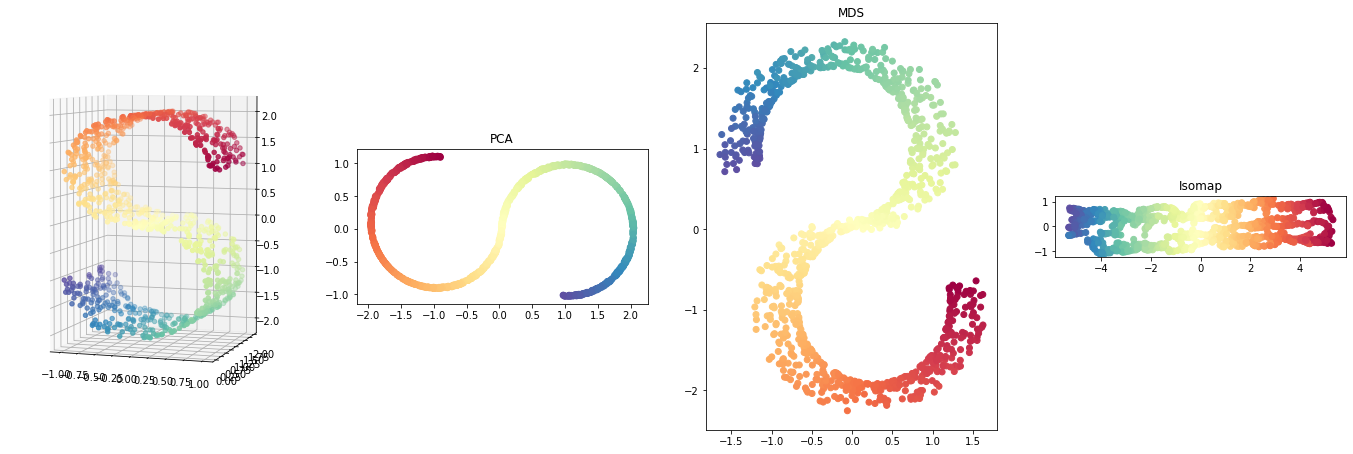

In [4]:
compare_methods( X_s, color_s, 
                [ PCA(n_components=2), 
                MDS(2, max_iter=100, n_init=1),
                Isomap( n_components=2 ) ])

In [5]:
X_swr, color_swr = sklearn.datasets.make_swiss_roll(n_samples=1000, noise=0.01 )

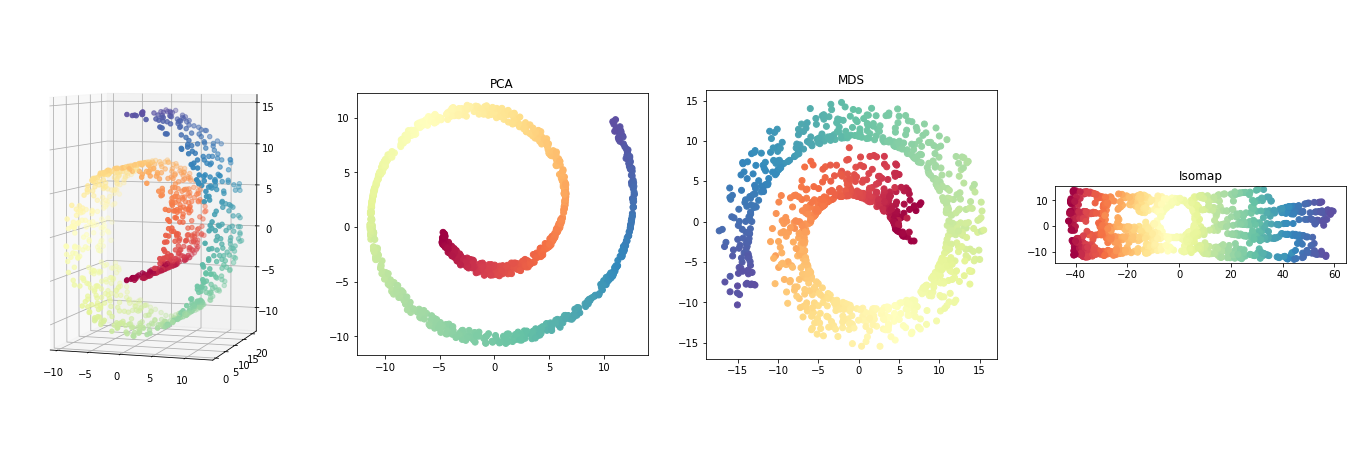

In [6]:
compare_methods( X_swr, color_swr, 
                [ PCA(n_components=2), 
                MDS(2, max_iter=100, n_init=1),
                Isomap( n_components=2, n_neighbors=5 ) ])

## High dimensional data is ok

( if it's nice )

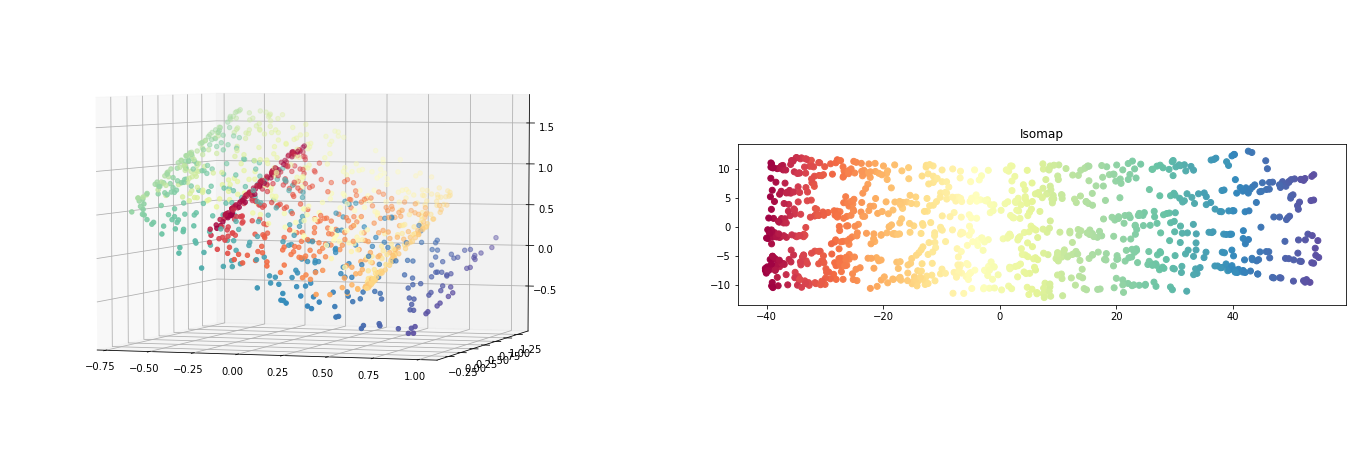

In [181]:
# A random 500d orthonormal matrix
R = scipy.stats.ortho_group.rvs( 500 )
R3 = R[:,:3]

# nicely project our data up to 500d
X_swr_up = X_swr @ R3.T 
X_swr_up.shape

compare_methods( X_swr_up, color_swr, [
    Isomap( n_components=2, n_neighbors=7 )
    ] )

# Multidimensional Scaling (MDS)


Potentially high-dim data ($\mathbf{y}_i$), but work directly on pairwise distances:

* $\mathbf{D} = [d_{ij}] = \mathrm{distance}( y_i, y_j) $

Find low-dim data $\mathbf{x}_i$ that minimizes:

* $\Sigma_i \Sigma_{j \neq i} (  || \mathbf{x}_i -\mathbf{x}_j || - d_{ij})^2 $


## Method
1. "Double-center" distance matrix
  * B = $-\frac{1}{2}JD^2J$


2. Eigen-decompose $B$:
  * B = $U \Lambda U^T$


3. First $k$ eigenvectors yield low-dim space
  * $X = U_k \Lambda_k^{\frac{1}{2}}$

### Why center distances?

Our original distance matrix is

$ D^2 = [d^2_{ij}] = (y_i - y_j)^T (y_i - y_j) $


Instead of working with $D^2$, we'll work with:

$B = -\frac{1}{2} J D^2 J $
    
$ B = (J Y )^T ( J Y ) = J Y^T Y   = \bar{Y}^T \bar{Y} $

$ b_{ij} = (y_i - \bar{y})^T (y_j - \bar{y})$


#### "The kernel trick for distances"

Rewrite the elements of $D^2$

$d^2_{ij} = (y_i - y_j)^T (y_i - y_j)$


Rewrite the elements of $B^2$:

$ b_{ij} = (y_i - \bar{y})^T (y_j - \bar{y})$

It's invariant to fixed translations of all points. Expand out:

$ b_{ij} = [(y_i - \bar{y}) - (y_j - \bar{y}) ]^T [(y_i - \bar{y}) - (y_j - \bar{y}) ]$

collecting things together gets;

$ \; = \frac{1}{2}( -|| y_i - y_j || + || y_i - \bar{y} || + || y_j - \bar{y} ||)$


Conclusion, for a fixed $\bar{y}$, we get a similarity measure $b_ij$ for every dissimilarity || y_i - y_j ||

### Does this really work?

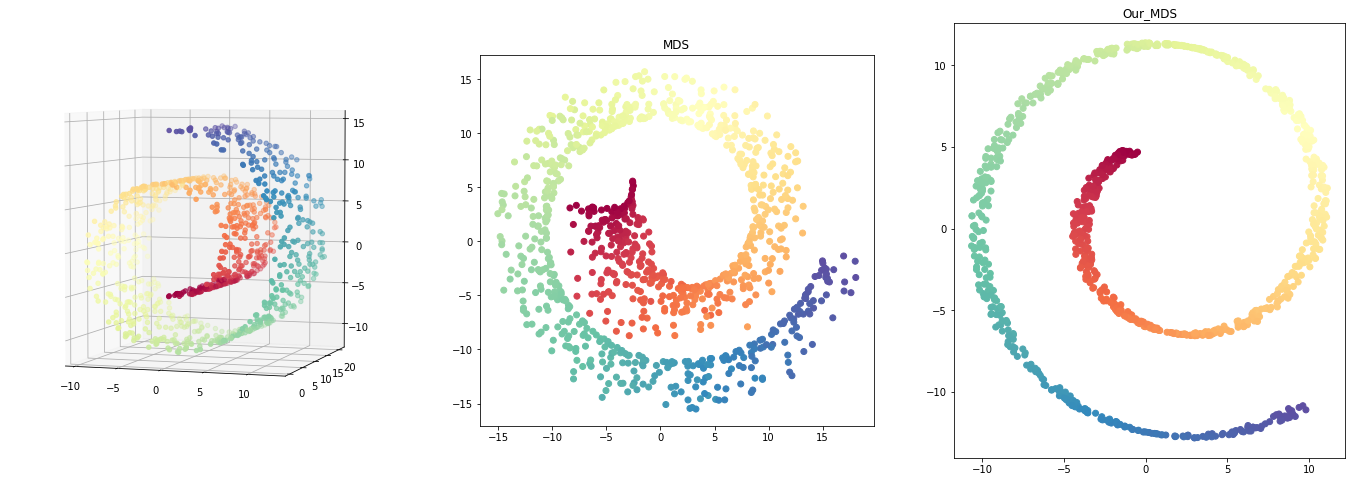

In [230]:

def centering_mtx( N ):
    return np.identity(N) - np.ones(N) / N

class Our_MDS:
    n_dims =1 
    def __init__(self, n_dims):
        self.n_dims = n_dims
    
    def fit_transform( self, X ):
        # Squared distances
        D = sklearn.metrics.pairwise.euclidean_distances( X, squared=True )
        J = centering_mtx( X.shape[0])
        B = -0.5 * J @ D @ J
        evals, eVecs = np.linalg.eigh( B )
        s = np.diagflat( np.sqrt( evals[-self.n_dims:] ) ) # Lambda^(1/2)
        v = eVecs[:, -self.n_dims:] 
        return v @ s

compare_methods( X_swr, color_swr, [
    MDS( 2, max_iter=100, n_init=1),
    Our_MDS( 2 ) ] )

## References

Cox, T.F.; Cox, M.A.A. (2001). Multidimensional Scaling.

Kruskal, J. B., and Wish, M. (1978),

Williams "On a Connection between Kernel PCA and Metric Multidimensional Scaling"

["The kernel trick for distances"](https://papers.nips.cc/paper/1862-the-kernel-trick-for-distances.pdf)

[Lecture notes on MDS and Isomap](http://www.math.uwaterloo.ca/~aghodsib/courses/f10stat946/notes/lec10-11.pdf)

https://www.youtube.com/watch?v=RPjPLlGefzw

# Finding shortest paths with Dijkstra's algorithm
(1956)


![Image](dijkstra.gif)

# Isomap failure modes

## Too few samples

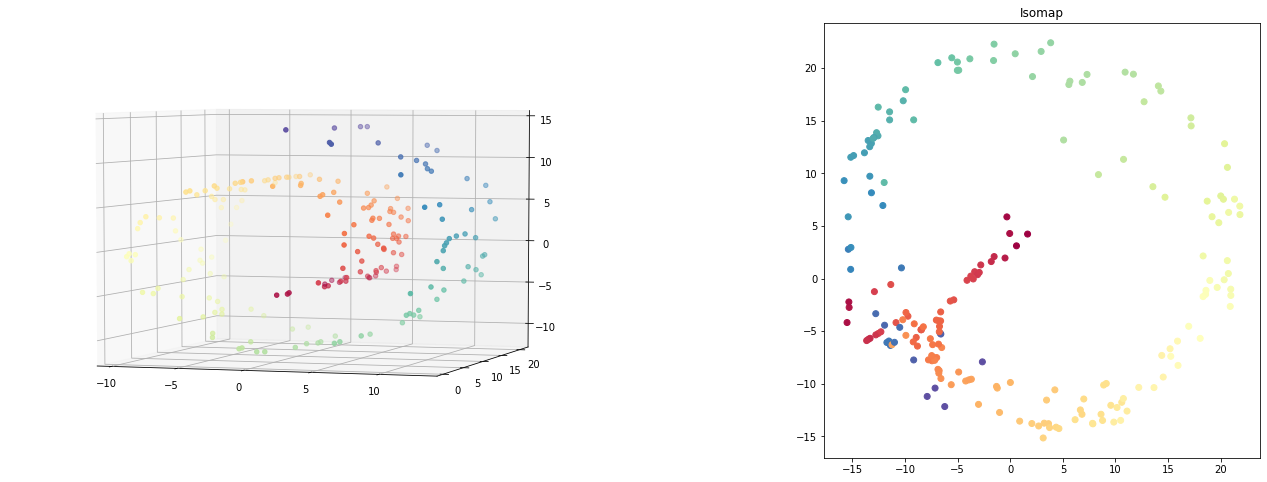

In [113]:
X_loN, color_loN = sklearn.datasets.make_swiss_roll(n_samples=200, noise=0.01 )
compare_methods( X_loN, color_loN, [ Isomap( n_components=2, n_neighbors=5 ) ])

## High noise

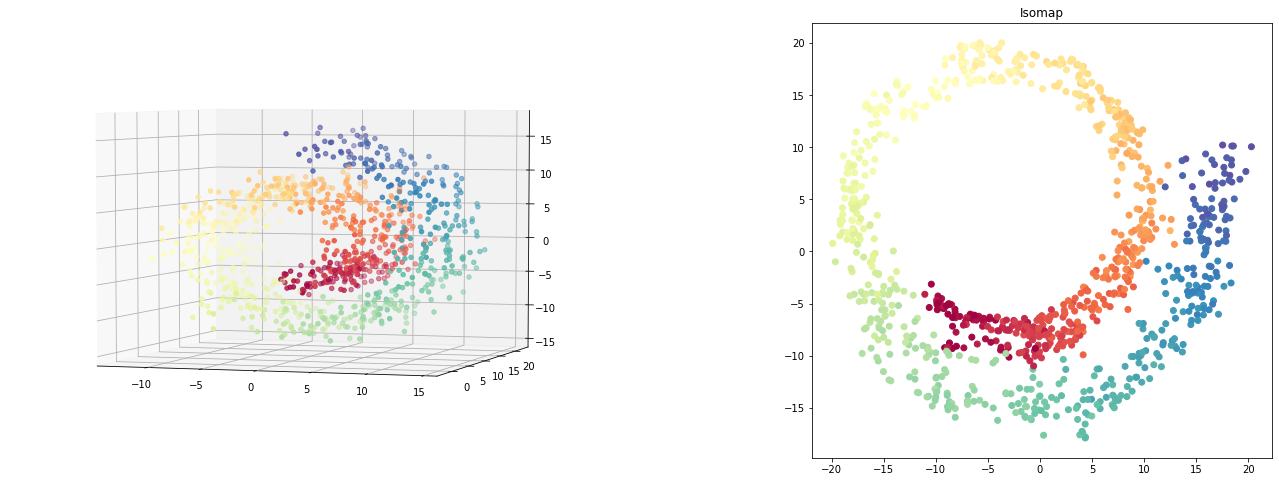

In [127]:
X_loN, color_loN = sklearn.datasets.make_swiss_roll(n_samples=1000, noise=1.2 )
compare_methods( X_loN, color_loN, [ Isomap( n_components=2, n_neighbors=5 ) ])

# Non isotropic variable scaling

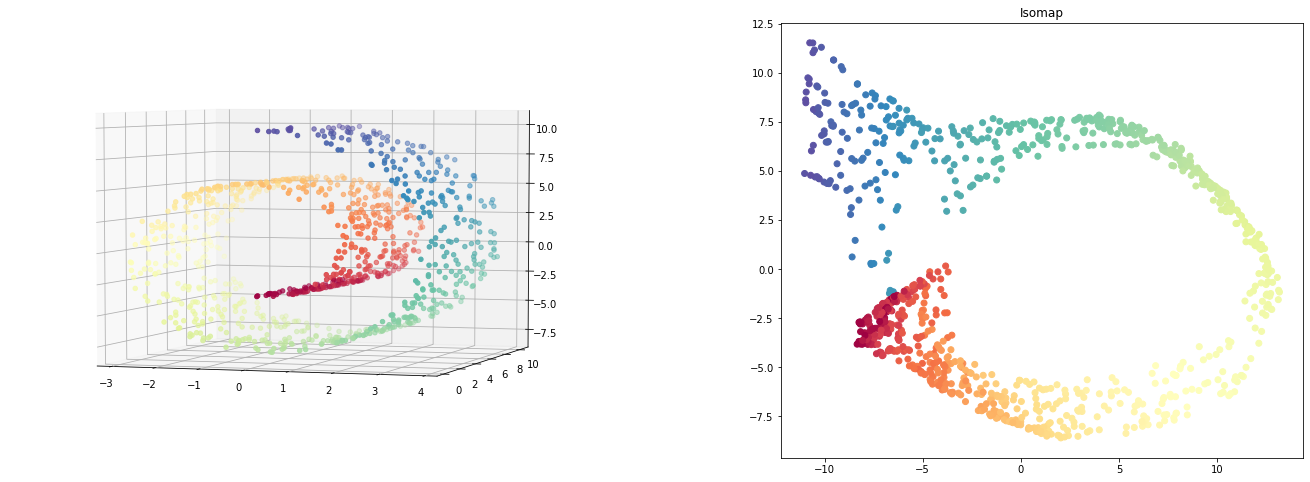

In [174]:
scaling = np.diagflat(np.array([0.3,0.5,0.7]))
X_swr_scaled = X_swr @  scaling

compare_methods( X_swr_scaled, color_swr, [ Isomap( n_components=2, n_neighbors=7 ) ] )

## Poor parameter choice

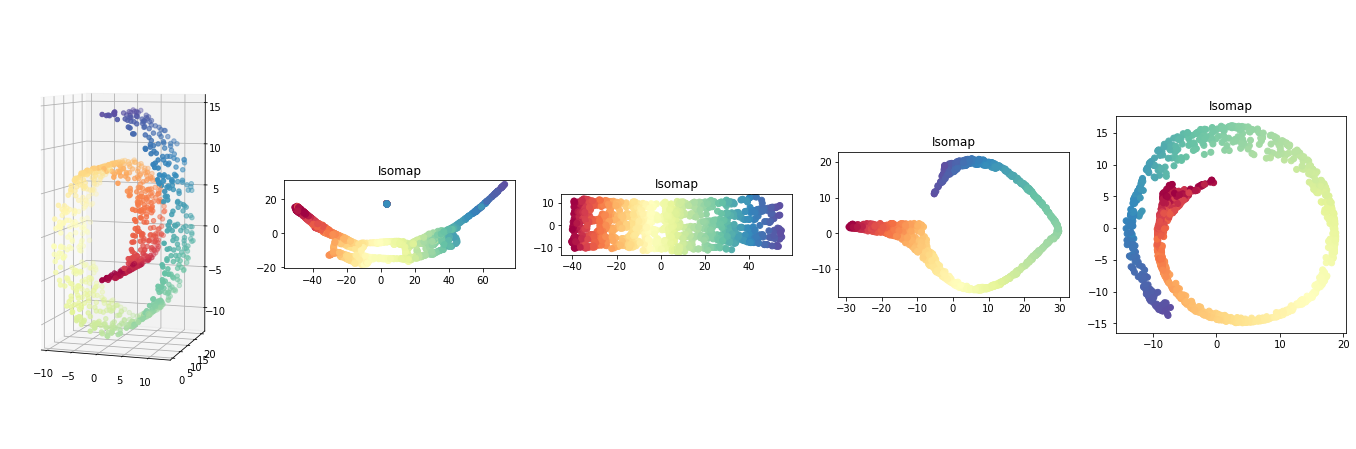

In [137]:
compare_methods( X_swr, color_swr, [
    Isomap( n_components=2, n_neighbors=3 ),
    Isomap( n_components=2, n_neighbors=7 ),
    Isomap( n_components=2, n_neighbors=15 ),
    Isomap( n_components=2, n_neighbors=31 )] )

# An application

Chaudhuri et al. "The population dynamics of a canonical cognitive circuit" Nature neuroscience 2019


_If a circuit represents a low-dimensional variable of given dimension and topology, the high-dimensional states of the circuit will be localized to a low-dimensional subspace or manifold of matching dimension and topology._

* Look for 1d ring manifold for head direction representation in mouse
* Persistent homology (topological data analys) to find likely topology/dimension of subspace
* **Isomap for dimensionality reduction and visualization**
* Fit low-d spline to the manifod: the "latent variable"

### Isomap preprocessing

Neuronal state-space is very high-dimensional.  Reduce dimensionality for practical reasons (e.g. so spline fitting is faster).


* "This visualization provides a compelling mammalian parallel to the beautiful recent results on a topographically ordered HD ring in the invertebrate nervous system"


* "A manifold approach reveals the full N-point correlations of the circuit, directly uncovering a structure that cannot easily be obtained from individual neural responses and pairwise correlations, including that there is little structure beyond a single 1D ring ..."


* "Manifold characterization with topological data analysis followed by parameterization in local coordinates as done here rather than by global low-dimensional embedding (as done by, for example, PCA and Isomap) will be important for unsupervised decoding of higher-dimensional manifolds that are topologically nontrivial, for example, toroidal structures produced by simulated grid cells"

![Image](Chaudhuri_Fig1.png)

a) isomap

b) VAE 


c) outlier removal

d) no outlier removal


![Image](Chaudhuri_FigS1.png)

![Image](Chaudhuri_FigS2.png)

# Extras
